# Naiwny klasyfikator Bayesa

Rozważymy klasyczny problem klasyfikacji odmian irysów na podstawie cech płatków. Jest to klasyczny już problem, często wykorzystywany przy porównywaniu różnych technik klasyfikacji. Więcej o pochodzeniu tych danych i problemie można przeczytać tu: [Iris_flower_data](https://en.wikipedia.org/wiki/Iris_flower_data_set)

W tym notatniku użyjemy naiwnego klasyfikatora Bayesa. Kod napiszemy w oparciu o implementacje klasyfikatora Bayesa z biblioteki [scikit-learn](http://scikit-learn.org/stable/about.html#citing-scikit-learn)

Zaczerpniemy stamtąd:
* obiekt klasyfikatora [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html),
* zbiór danych,
* funkcje do oceny jakości klasyfikacji

### Przygotowanie środowiska programistycznego

In [1]:
import numpy as np
from termcolor import colored

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

## Wczytanie danych do analizy

Zbiór danych ``Iris`` jest dostępny w bibliotece sklearn jako jeden z wielu standardowych zbiorów [testowych](https://scikit-learn.org/stable/datasets/toy_dataset.html).

In [2]:
#Wczytywanie danych
iris = datasets.load_iris() 

#Wypisywanie zawartości wczytanego obiektu
print(dir(iris))

['DESCR', 'data', 'data_module', 'feature_names', 'filename', 'frame', 'target', 'target_names']


## Analiza zawartości danych

**Proszę** wypisać:

* nazwy gatunków,
* kodowanie gatunków, czyli liczby przypisane do nazw gatunków ```target```,
* nazwy zmiennych opisujących gatunki ```feature_names```,

**Wskazówka**: informacje o zbiorze uzyskujemy traktując go jak słownik:
```Python
print(iris['filename'])
```

In [3]:
#BEGIN_SOLUTION
print(iris['target_names'])
print(iris['target'])
print(iris['feature_names'])
#END_SOLUTION
print(iris['DESCR'])

['setosa' 'versicolor' 'virginica']
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ======

## Przepisane danych do obiektu Pandas DataFrame

**Proszę** utworzyć obiekt DataFrame zawierający własności ("features") oraz etykiety ("label")
* przypisać poprawne nazwy kolumn: ```columns=iris.feature_name```,
* dodać do obiektu DataFrame kolumnę ```label``` zawierającą etykiety,
* wypisać własności przykładu o indeksie 5
* sprawdzić jaki gatunek odpowiada wartości etykiety przykładu o indeksie 5.

**Wskazówka:** można skorzystać z funkcji DataFrame.loc(index)

Oczekiwany wynik:
```Python
sepal length (cm)    5.4
sepal width (cm)     3.9
petal length (cm)    1.7
petal width (cm)     0.4
label                0.0
Name: 5, dtype: float64
Gatunek przykładu o indeksie 5: setosa
```

In [4]:
#BEGIN_SOLUTION
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["label"] = iris.target
print(df.describe())
print(df.loc[5])
example_species = iris.target_names[df["label"][5]]
#END_SOLUTION

print(colored("Gatunek przykładu o indeksie 5:","blue"), example_species)

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000           5.100000   
max             7.900000          4.400000           6.900000   

       petal width (cm)       label  
count        150.000000  150.000000  
mean           1.199333    1.000000  
std            0.762238    0.819232  
min            0.100000    0.000000  
25%            0.300000    0.000000  
50%            1.300000    1.000000  
75%            1.800000    2.000000  
max            2.500000    2.000000  
sepal length (cm)    5.4
sepal width (cm)     3.9
petal length (cm)    1

## Analiza wizualna danych. 

Pierwszy krok przy analizie danych z użyciem dowolnego algorytmu to ich inspekcja. Korzystając z metod klasy `DataFrame`.

**Proszę:**
* narysować jednowymiarowe histogramy dla wszystkich zmiennych (kolumn obiektu DataFrame)

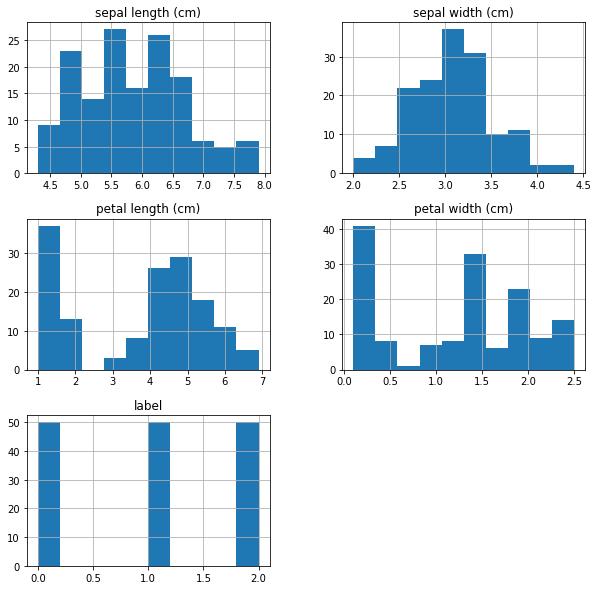

In [5]:
#BEGIN_SOLUTION
df.hist(figsize=(10,10));
#END_SOLUTION
pass

Naszym zadaniem jest rozdzielenie gatunków na podstawie własności. Poniższa komórka rysuje rozkłady (histogramy) własności w podziale na  gatunki. 

**Proszę:**

* na podstawie histogramów proszę zidentyfikować cechy, które najlepiej odróżniają gatunki.

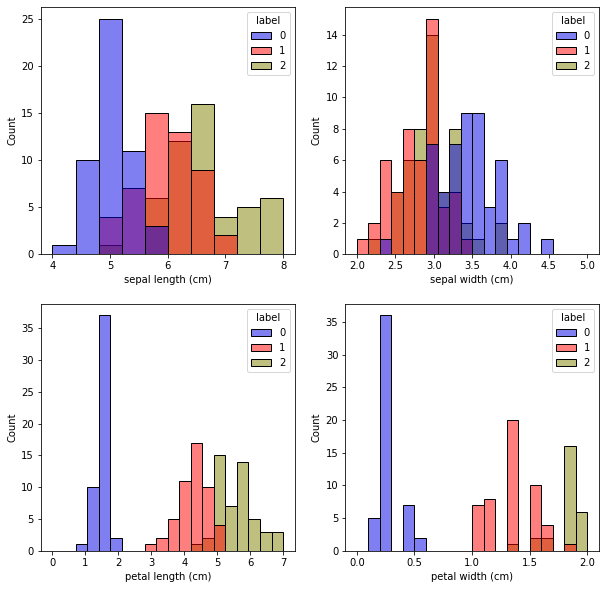

In [6]:
fig, axes = plt.subplots(2,2, figsize=(10,10))
color_map = {-1: (1, 1, 1), 0: (0, 0, .9), 1: (1, 0, 0), 2: (.5, .5, 0)}

sns.histplot(data=df, x="sepal length (cm)", hue="label", binrange=(4,8),palette=color_map, bins=10, ax=axes[0,0]);
sns.histplot(data=df, x="sepal width (cm)", hue="label", palette=color_map, binrange=(2,5), bins=20, ax=axes[0,1]);
sns.histplot(data=df, x="petal length (cm)", hue="label", palette=color_map, binrange=(0,7), bins=20, ax=axes[1,0]);
sns.histplot(data=df, x="petal width (cm)", hue="label", palette=color_map, binrange=(0,2), bins=20, ax=axes[1,1]);

## Wykres skrzypcowy ("violin plot")

Histogramy dla poszczególnych gatunków się nakładają częściowo. Inny sposób wizualizacji to wykres skrzypcowy (ang. "violin plot"). Poniższa komórka
rysuje wykresy skrzypcowe dla poszczególnych cech z podziałem na gatunki.

**Proszę:**

* na podstawie rysunków proszę zidentyfikować cechy, które najlepiej odróżniają gatunki.

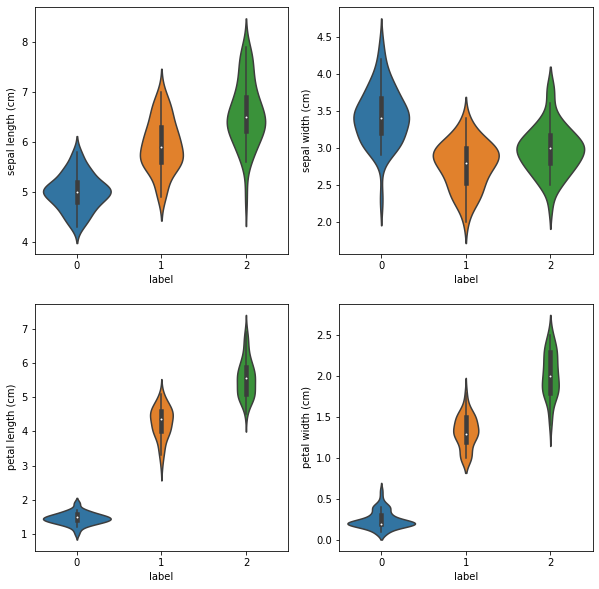

In [7]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

for index, columnName in enumerate(df.columns[0:4]):
    sns.violinplot(data=df, x="label", y=columnName,ax=axes[(int)(index/2),index%2]);   

## Analiza dwuwymiarowa

Rysunki narysowane do tej pory były jednowymiarowe. Kolejny krok to wizualna analiza korelacji między cechami. Korelację między cechami można zwizualizować na wiele sposobów. Poniższa komórka rysuje:

* macierz kowariancji między wszystkimi kolumnami danych włączając etykiety
* dwuwymiarowe rozkłady dla par cech

Więcej przykładów wyzualizacji można znaleźć [w dokumentacji](https://seaborn.pydata.org/tutorial/axis_grids.html).

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   
label                       0.782561         -0.426658           0.949035   

                   petal width (cm)     label  
sepal length (cm)          0.817941  0.782561  
sepal width (cm)          -0.366126 -0.426658  
petal length (cm)          0.962865  0.949035  
petal width (cm)           1.000000  0.956547  
label                      0.956547  1.000000  


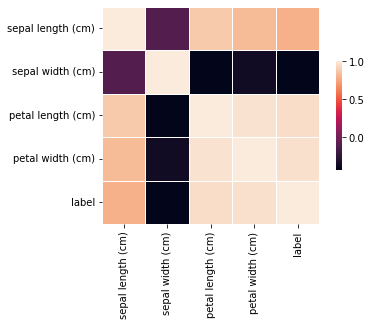

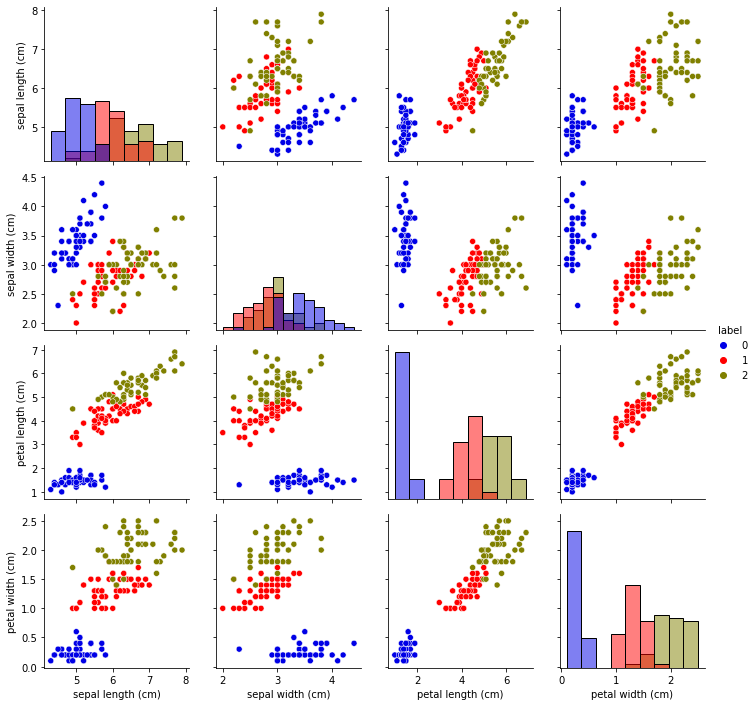

In [8]:
corelationMatrix = df.corr()
print(corelationMatrix)

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corelationMatrix, square=True, linewidths=.5, cbar_kws={"shrink": .5});

graph = sns.PairGrid(df, hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

## Przygotowanie danych wejściowych (ang. preprocessing)

Od tego momentu, aby ułatwić analizę wyniku działania modelu ograniczymy się do dwu cech - wtedy będzie można narysować podział na gatunki na płaszczyźnie.

Standardową procedurą obróbki danych przed utworzeniem modelu jest ich normalizacja, najlepiej do zakresu [-1,1] lub [0,1].
Znormalizujemy wartości cech według wzoru:

\begin{equation}
x_{norm} = \frac{x - \mu_{x}}{\sigma_{x}}
\end{equation}

**Proszę:**

* utworzyć nowy obiekt DataFrame zawierający znormalizowane kolumny własności oraz etykiety: ```df_normalized``` 
* utworzyć obiekt DataFrame zawierający tylko wybrane cechy, oraz etykiety: ```["sepal width (cm)","petal length (cm)", "label"]```: ```df_subset```
* wypisać zawartość obiektów ```df_normalized``` i ```df_subset```. Czy widać efekt normalizacji?

**Uwaga:** proszę nie normalizować wartości etykiet

In [9]:
#BEGIN_SOLUTION
df_normalized = (df - df.mean())/df.std()
df_normalized["label"] = df["label"]
df_subset = df_normalized[["sepal width (cm)","petal length (cm)", "label"]]
#END_SOLUTION

print(colored("Normalized dataset:","blue"))
print(df_normalized.describe())
print(colored("Normalized dataset with only two features:","blue"))      
print(df_subset.describe())

Normalized dataset:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count       1.500000e+02      1.500000e+02       1.500000e+02   
mean       -1.515825e-15     -1.894781e-15      -1.515825e-15   
std         1.000000e+00      1.000000e+00       1.000000e+00   
min        -1.863780e+00     -2.425820e+00      -1.562342e+00   
25%        -8.976739e-01     -5.903951e-01      -1.222456e+00   
50%        -5.233076e-02     -1.315388e-01       3.353541e-01   
75%         6.722490e-01      5.567457e-01       7.602115e-01   
max         2.483699e+00      3.080455e+00       1.779869e+00   

       petal width (cm)       label  
count      1.500000e+02  150.000000  
mean      -8.526513e-16    1.000000  
std        1.000000e+00    0.819232  
min       -1.442245e+00    0.000000  
25%       -1.179859e+00    0.000000  
50%        1.320673e-01    1.000000  
75%        7.880307e-01    2.000000  
max        1.706379e+00    2.000000  
Normalized dataset with only two features:
       se

**Proszę:** 
* narysować dwuwymiarowe rozkłady dla par cech dla znormalizowanych danych z dwiema cechami.

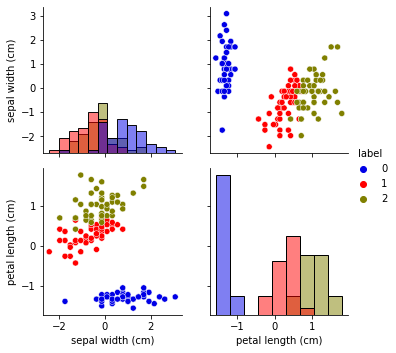

In [10]:
#BEGIN_SOLUTION
graph = sns.PairGrid(df_subset, hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();
#END_SOLUTION
pass

## Definicja i trening klasyfikatora

W tym notatniku użyjeny klasyfikatora [naive bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) w wersji gaussowskiej.

**Proszę:**

* utworzyć obiekt ```gnb``` klasy [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
* przeprowadzić trening z użyciem funkcji ```fit()```

In [11]:
#BEGIN_SOLUTION
gnb = GaussianNB()
X = df_subset.drop(columns="label")
Y = df_subset["label"]
gnb.fit(X, Y)
#END_SOLUTION
print(colored("Accuracy on train dataset: ","blue"), gnb.score(X,Y))

Accuracy on train dataset:  0.92


**Proszę:**


* wypisać wartości parametrów modelu: średnie i odchylenia standardowe rozkładów Gaussa. Średnie znajdują się w polu  ```gnb.theta_```, a wariancje
  w ```gnb.var_```
* wypisać średnie i odchylenia standardowe rozkładów cech w podziale na gatunki obliczone z danych
* porównać uzyskane wartości. Czy liczby są zgodne z oczekiwaniami? 

**Wskazówka:** proszę skorzystać z grupowania danych: `DataFrame.groupby()`.

Oczekiwany wynik dla parametrów z modelu:
```Python
Mean:
 [[ 0.85041372 -1.30063009]
 [-0.65922358  0.28437121]
 [-0.19119013  1.01625888]]
Sigma:
 [[0.86093968 0.09738785]
 [0.71270594 0.26351816]
 [0.73246175 0.30949324]]
```

In [12]:
#BEGIN_SOLUTION
print(colored("Mean from fit:\n","blue"),gnb.theta_)
print(colored("Sigma from fit:\n","blue"),np.sqrt(gnb.var_))
print(colored("Mean from data:","blue"))
print(df_subset.groupby("label").mean())
print(colored("Standard deviation from data:","blue"))
print(df_subset.groupby("label").std(ddof=0))
#END_SOLUTION
pass

Mean from fit:
 [[ 0.85041372 -1.30063009]
 [-0.65922358  0.28437121]
 [-0.19119013  1.01625888]]
Sigma from fit:
 [[0.86093968 0.09738785]
 [0.71270594 0.26351816]
 [0.73246175 0.30949324]]
Mean from data:
       sepal width (cm)  petal length (cm)
label                                     
0              0.850414          -1.300630
1             -0.659224           0.284371
2             -0.191190           1.016259
Standard deviation from data:
       sepal width (cm)  petal length (cm)
label                                     
0              0.860940           0.097388
1              0.712706           0.263518
2              0.732462           0.309493


### Porównanie dopasowanych rozkładów z danymi.
Komórki poniżej zawierają funkcje:

* ```plot_2d_gaussian(mean, covariance, axis)``` - funkcja która rysuje dwuwymiarowy rozkład Gaussa o średniej ```mean``` i diagonalej macierzy kowariancji ```np.diag(cov)``` na obszarze danym przez obiekt ```axis```,
* ```plot_2d_divison(model, axis)``` - funkcja która rysuje kontury podziału na klasy na podstawie modelu ```model``` na obszarze danym przez obiekt ```axis```.

In [13]:
def plot_2d_gaussian(mean, cov, axis):
    xx, yy = np.mgrid[-3:3:0.1, -3:2:0.1]
    pos = np.dstack((xx, yy))
    zz = multivariate_normal.pdf(pos, mean=mean, cov=np.diag(cov))
    axis.contour(xx, yy, zz, 10) 
    
def plot_2d_divison(model, axis):
    xx, yy = np.mgrid[-4:4:0.1, -4:4:0.1]  
    pos = np.c_[xx.ravel(), yy.ravel()]
    zz = model.predict(pos)
    zz = np.reshape(zz, xx.shape)
    axis.contour(xx, yy, zz, cmap=plt.cm.Paired)

Poniższa komórka rysuje:

* dwuwymiarowy rozkład danych dla analizowanego zbioru. Punkty są pokolorowane według przynależności do gatunku,
* fukcja ```plot_2d_gaussian(mean, covariance, axis)``` rysuje na tym samym rysunku poziomnice rozkładów Gaussa modelu ```gnb = GaussianNB()```.

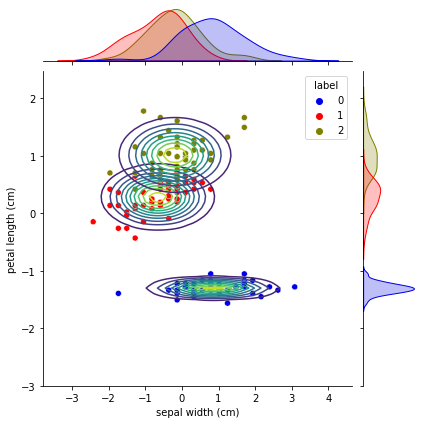

In [14]:
graph = sns.jointplot(x="sepal width (cm)", y="petal length (cm)", data=df_subset, hue="label", palette=color_map)

for classNumber in range(0,3): 
    plot_2d_gaussian(mean=gnb.theta_[classNumber], cov=np.diag(gnb.var_[classNumber]), axis=graph.ax_joint)  

**Proszę:** 

* korzystając z funkcji ```sns.jointplot``` narysować dwuwymiarowy rozkład danych dla analizowanego zbioru. Punkty powinny być pokolorowane według przynależności do gatunku,
* korzystając z funkcji ```plot_2d_divison(model, axis)``` nanieść granice podziału na gatunki.

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


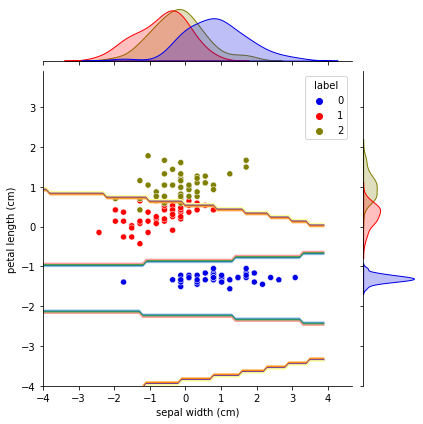

In [15]:
#BEGIN_SOLUTIONS
graph = sns.jointplot(x="sepal width (cm)", y="petal length (cm)", data=df_subset, hue="label", palette=color_map)
plot_2d_divison(model=gnb, axis=graph.ax_joint)
#END_SOLUTIONS
pass

## Analiza jakości modelu
Korzystając z walidacji krzyżowej przeprowadzimy analizę miar jakości modeli. Skorzystamy z funkcji opisanych w rozdziale [Model evaluation](http://scikit-learn.org/stable/modules/model_evaluation.html) dokumentacji pakietu scikit-learn.

**Proszę:**

* przejrzeć listę dostępnych metryk i upewnić się, co dokładnie zwracają poszcególne funkcje,
* porównać definicje z scikit-learn z definicjami z [wykładu](https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/Wyk%C5%82ad_Ocena_jako%C5%9Bci_klasyfikacji),
* uzupełnić kod funkcji ```printScores(model, X, Y)```, która przyjmuje ```model```, cechy ```X``` oraz etykiety ```Y``` i wypisuje
  raport o klasyfikacji oraz macierz pomyłek
  
Oczekiwany wynik:
```Python
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.85      0.92      0.88        50
           2       0.91      0.84      0.87        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150

Confusion matrix:
[[50  0  0]
 [ 0 46  4]
 [ 0  8 42]]
```

In [16]:
def printScores(model, X, Y):
    print("Classification report:")
    #BEGIN_SOLUTION
    print(classification_report(Y, model.predict(X)))
    #END_SOLUTION
    print("Confusion matrix:")
    #BEGIN_SOLUTION
    print(confusion_matrix(Y, model.predict(X)))
    #END_SOLUTION
    
printScores(gnb, X, Y)  

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.85      0.92      0.88        50
           2       0.91      0.84      0.87        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150

Confusion matrix:
[[50  0  0]
 [ 0 46  4]
 [ 0  8 42]]


## Porównanie  modeli

**Proszę:**

Stworzyć trzy modele klasyfikatorów:

* korzystający z cech ```["sepal width (cm)","petal length (cm)"]``` (nasz dotychczasowy model): ```gnb_features_1_2```
* korzystający tylko z cech ```["sepal length (cm)","sepal width (cm)"]```: ```gnb_features_0_1```
* korzystający ze wszytkich czterech cech: ```gnb_features_all```
* dla każdego z modeli wypisać wartości miar jakości i na ich podstawie stwierdzić który model jest najlepszy

In [17]:
print(colored("Model using","blue"), "sepal width and petal length", colored("features:", "blue"))
#BEGIN_SOLUTION
df_subset = df_normalized[["sepal width (cm)","petal length (cm)", "label"]]
X = df_subset.drop(columns="label")
Y = df_subset["label"]

gnb_features_1_2 = GaussianNB()
gnb_features_1_2.fit(X, Y);
printScores(gnb_features_1_2, X, Y)
#END_SOLUTION

print(colored("Model using","blue"), "sepal length and sepal width", colored("features:", "blue"))
#BEGIN_SOLUTION
df_subset = df_normalized[["sepal length (cm)","sepal width (cm)", "label"]]
X = df_subset.drop(columns="label")
Y = df_subset["label"]

gnb_features_0_1 = GaussianNB()
gnb_features_0_1.fit(X, Y);
printScores(gnb_features_0_1, X, Y)
#END_SOLUTION

print(colored("Model using","blue"), "all", colored("features:", "blue"))
#BEGIN_SOLUTION
df_subset = df_normalized
X = df_subset.drop(columns="label")
Y = df_subset["label"]

gnb_features_all = GaussianNB()
gnb_features_all.fit(X, Y);
printScores(gnb_features_all, X, Y)
#END_SOLUTION

pass

Model using sepal width and petal length features:
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.85      0.92      0.88        50
           2       0.91      0.84      0.87        50

    accuracy                           0.92       150
   macro avg       0.92      0.92      0.92       150
weighted avg       0.92      0.92      0.92       150

Confusion matrix:
[[50  0  0]
 [ 0 46  4]
 [ 0  8 42]]
Model using sepal length and sepal width features:
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       0.65      0.74      0.69        50
           2       0.70      0.62      0.66        50

    accuracy                           0.78       150
   macro avg       0.78      0.78      0.78       150
weighted avg       0.78      0.78      0.78       150

Confusion matrix:
[[49  1  0]
 [ 0 

## Analiza wpływu normalizacji danych.

**Proszę:**

* wytrenować model na wszytkich cechach, ale korzystając z oryginalnych danych - bez normalizacji wartości cech,
* wypisać wartości miar jakościdla uzyskanego modelu

Czy normalizacja wpływa na wydajność naszego modelu?

In [18]:
print(colored("Model using","blue"), "all", colored("features:", "blue"), "without normalisation")
#BEGIN_SOLUTION
df_subset = df
X = df_subset.drop(columns="label")
Y = df_subset["label"]

gnb_features_all = GaussianNB()
gnb_features_all.fit(X, Y);
printScores(gnb_features_all, X, Y)
#END_SOLUTION
pass

Model using all features: without normalisation
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.94      0.94        50
           2       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150

Confusion matrix:
[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]


# Zadanie domowe

## Dekorelacja zmiennych.
Niektóre zmienne są silnie skorelowane - algorytm "naiwny" nie radzi sobie z tym dobrze. 

**Proszę** wytenować modele na następujących danych  normalizacji):

* zawierających dwie silnie skorelowane cechy:
```Python 
["petal length (cm)","petal width (cm)"]
``` 
* zawierających ich zdekorelowane funkcje $x$ i $y$ będące sumą i różnicą skorelowanych zmiennych:
```Python
x = "petal length (cm)" + "petal width (cm)"
y = "petal length (cm)" - "petal width (cm)"
```
* proszę narysować dwuwymiarowe rozkłady dla zmiennych $x$ i $y$
* czy model używający zmiennych $x$ i $y$ jest lepszy/gorszy od modeli trenowanych wcześniej? Odpowiedź uzasadnij.

Scores for model using two correlated variables:
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.94      0.94        50
           2       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150

Confusion matrix:
[[50  0  0]
 [ 0 47  3]
 [ 0  3 47]]
Scores for model using decorelated variables:
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.98      0.97        50
           2       0.98      0.96      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion matrix:
[[50  0  0]
 [ 0 49  1]


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(


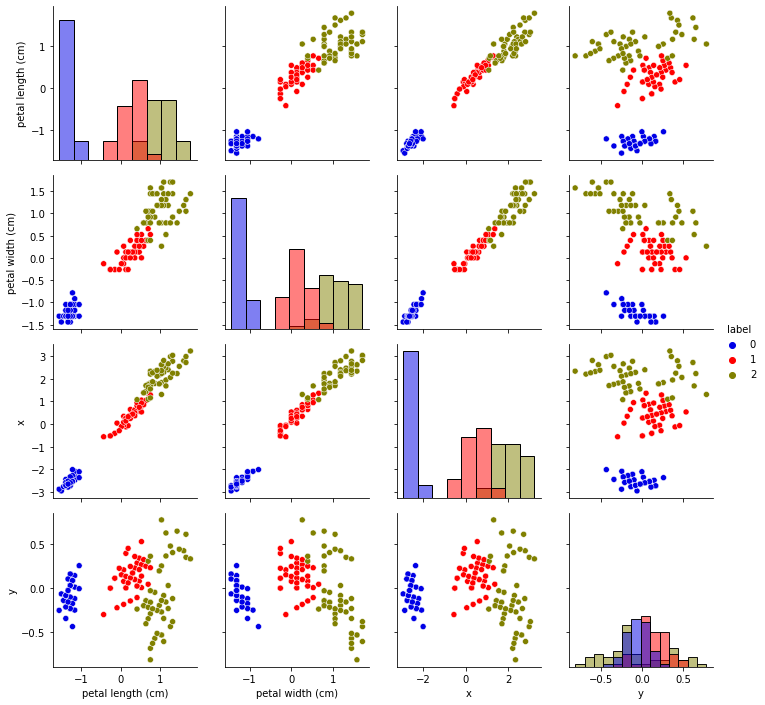

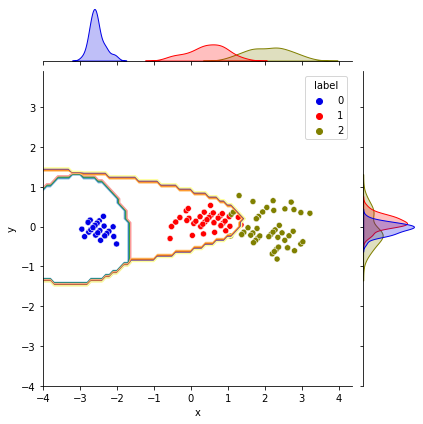

In [19]:
#BEGIN_SOLUTION
df_normalized["x"] = df_normalized["petal length (cm)"] + df_normalized["petal width (cm)"]
df_normalized["y"] = df_normalized["petal length (cm)"] - df_normalized["petal width (cm)"]
df_subset = df_normalized[["petal length (cm)","petal width (cm)", "x", "y","label"]]

graph = sns.PairGrid(df_subset, hue="label", palette=color_map)
graph.map_diag(sns.histplot)
graph.map_offdiag(sns.scatterplot);
graph.add_legend();

X = df_subset.drop(columns=["label","x","y"])
Y = df_subset["label"]

gnb_features_0_1 = GaussianNB()
gnb_features_0_1.fit(X, Y);
print(colored("Scores for model using two correlated variables:","blue"))
printScores(gnb_features_0_1, X, Y)

X = df_subset.drop(columns=["label","petal length (cm)","petal width (cm)"])
Y = df_subset["label"]
gnb_features_0_1 = GaussianNB()
gnb_features_0_1.fit(X, Y);
print(colored("Scores for model using decorelated variables:","blue"))
printScores(gnb_features_0_1, X, Y)

graph = sns.jointplot(x="x", y="y", data=df_subset, hue="label", palette=color_map)

plot_2d_divison(model=gnb_features_0_1, axis=graph.ax_joint)
#END_SOLUTION
pass